# Algorithmic Trading & Market Microstructure 22/23

GROUP ASSIGNMENT elaborated by:
    
    Riccardo Gurzu - 20221235 
    Rodrigo Maia - 20220517 
    Neftali Herculano - m20200732
    Francisco Feria - 20221538 

In [1]:
import yfinance as yf
import backtrader as bt
import numpy as np
import quantstats as qs
import pyfolio as pf
import pandas as pd
from backtrader.indicators import RSI
import itertools

/Users/riccardogurzu/.venv/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


The strategy analyzed in this project aims to capture trends based on the crossover of two exponential moving averages. When the shorter-term EMA crosses above the longer-term EMA, it generates a buy signal, indicating a potential upward trend. Conversely, when the shorter-term EMA crosses below the longer-term EMA, it generates a sell signal, indicating a potential downward trend. The Exponential Moving Average (EMA) is defined as follows:
$$
\operatorname{EMA}(T, \lambda)=\frac{\sum_{t=1}^T \lambda^{t-1} P(t)}{\sum_{t=1}^T \lambda^{t-1}}=\frac{1-\lambda}{1-\lambda^T} \sum_{t=1}^T \lambda^{t-1} P(t),
$$
where $t = 1$ corresponds to the most recent time in the time series of historical stock prices $P(t)$; $T$ is the length of the EMA ($t$ and $T$ are usually measured in trading days); and $\lambda < 1$ is the factor which suppresses past contributions.

The signal is given by:

$$
\text { Signal }=\left\{\begin{array}{l}
\text {Establish long/liquidate short position if } \mathrm{EMA}\left(T^{\prime}\right)>\mathrm{EMA}(T) \\
\text {Establish short/liquidate long position if } \mathrm{EMA}\left(T^{\prime}\right)<\mathrm{EMA}(T)
\end{array}\right.
$$

Using exponential moving averages (EMAs), instead simple moving averages (SMAs), gives a better responsiveness to price movements. Indeed EMAs are sensitive to recent price changes compared to SMAs. They assing more weight to recent data points, making them quicker to react to price movements. In this way, expecially analyzing an asset as BTC-EUR that is characterized by trends and changes in market condition, the use of EMAs allows to capture these changes faster, providing timely trading signals.
Considering again the characteristics of the asset analyzed, EMAs provide also smoother transitions during periods of price volatility or when a trend reverses. The exponential weighting of data helps reduce the lagging effect that can be observed with SMAs. As a result, EMAs can potentially generate signals with fewer false positives or false negatives during market transitions.

However, it's important to note that while EMAs offer advantages in terms of responsiveness and smoother transitions, they can also be more susceptible to false signals or increased noise in choppy or sideways markets. For this reason, in order to build a succesful trading strategy, is better to combine EMA signals with additional indicators (like RSI, MACD or Bollinger Bands) to make informed trading decisions based on your trading goals.
In our case we decided to combine the MA crossover with the Relative Strength Index (RSI), that is mostly used to help traders identify momentum, market conditions and warning signals for dangerous price movements. RSI is expressed as a figure between 0 and 100 where an asset around the 70 level is often considered overbought, while an asset at or near 30 is often considered oversold.

The Relative Strength Index (RSI) is calculated as follows:
$$
RSI(t) = 100 - \frac{100}{1 + RS(t)},
$$

where $RS(t)$ is the average gain of last $t$ trading days / Average loss of last $t$ trading days

In this way the signal of the strategy will be given by:
$$
\text { Signal }=\left\{\begin{array}{l}
\text {Establish long/liquidate short position if } \mathrm{EMA}\left(T^{\prime}\right)>\mathrm{EMA}(T) \text{ and } \mathrm{RSI}(t)>70\\
\text {Establish short/liquidate long position if } \mathrm{EMA}\left(T^{\prime}\right)<\mathrm{EMA}(T) \text{ and } \mathrm{RSI}(t)<30
\end{array}\right.
$$


In [2]:
# Define the ticker symbol for the asset
ticker = 'BTC-EUR'

# Set the start and end dates for the data
start_date = "2018-06-25"
end_date = "2023-06-25"  

# Fetch the historical price data using yfinance
df = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [3]:
class MyStrategy(bt.Strategy):
    params = (
        ('ema1_period', 50), # Period for the shorter-term EMA
        ('ema2_period', 100), # Period for the longer-term EMA
        ('period', 14) # Period for the RSI
    )

    def __init__(self):
        self.startcash = self.broker.getvalue()
        self.ema1 = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.ema1_period)
        self.ema2 = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.ema2_period)
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.period)
        self.crossover = bt.indicators.CrossOver(self.ema1, self.ema2) 

    def next(self):
        if not self.position:
            if self.crossover > 0 and self.rsi[0] > 70: # if EMA1 crosses above EMA2 and RSI is above 70
                self.buy()  # Generate a buy signal
            elif self.crossover < 0 and self.rsi[0] < 30: # if EMA1 crosses below EMA2 and RSI is below 30
                self.sell() # Generate a sell signal
        else:
            if self.crossover > 0 and self.rsi[0] > 70: # if EMA1 crosses above EMA2 and RSI is above 70
                self.close() # Close the existing position
                self.buy() # Generate a new buy signal
            elif self.crossover < 0 and self.rsi[0] < 30: # if EMA1 crosses below EMA2 and RSI is below 30
                self.close() # Close the existing position
                self.sell() # Generate a new sell signal

    def stop(self):
        if self.position: 
            self.close() # Closing open position at the end of the backtest

Starting Portfolio Value: 100000.00
Final Portfolio Value: 135889.46


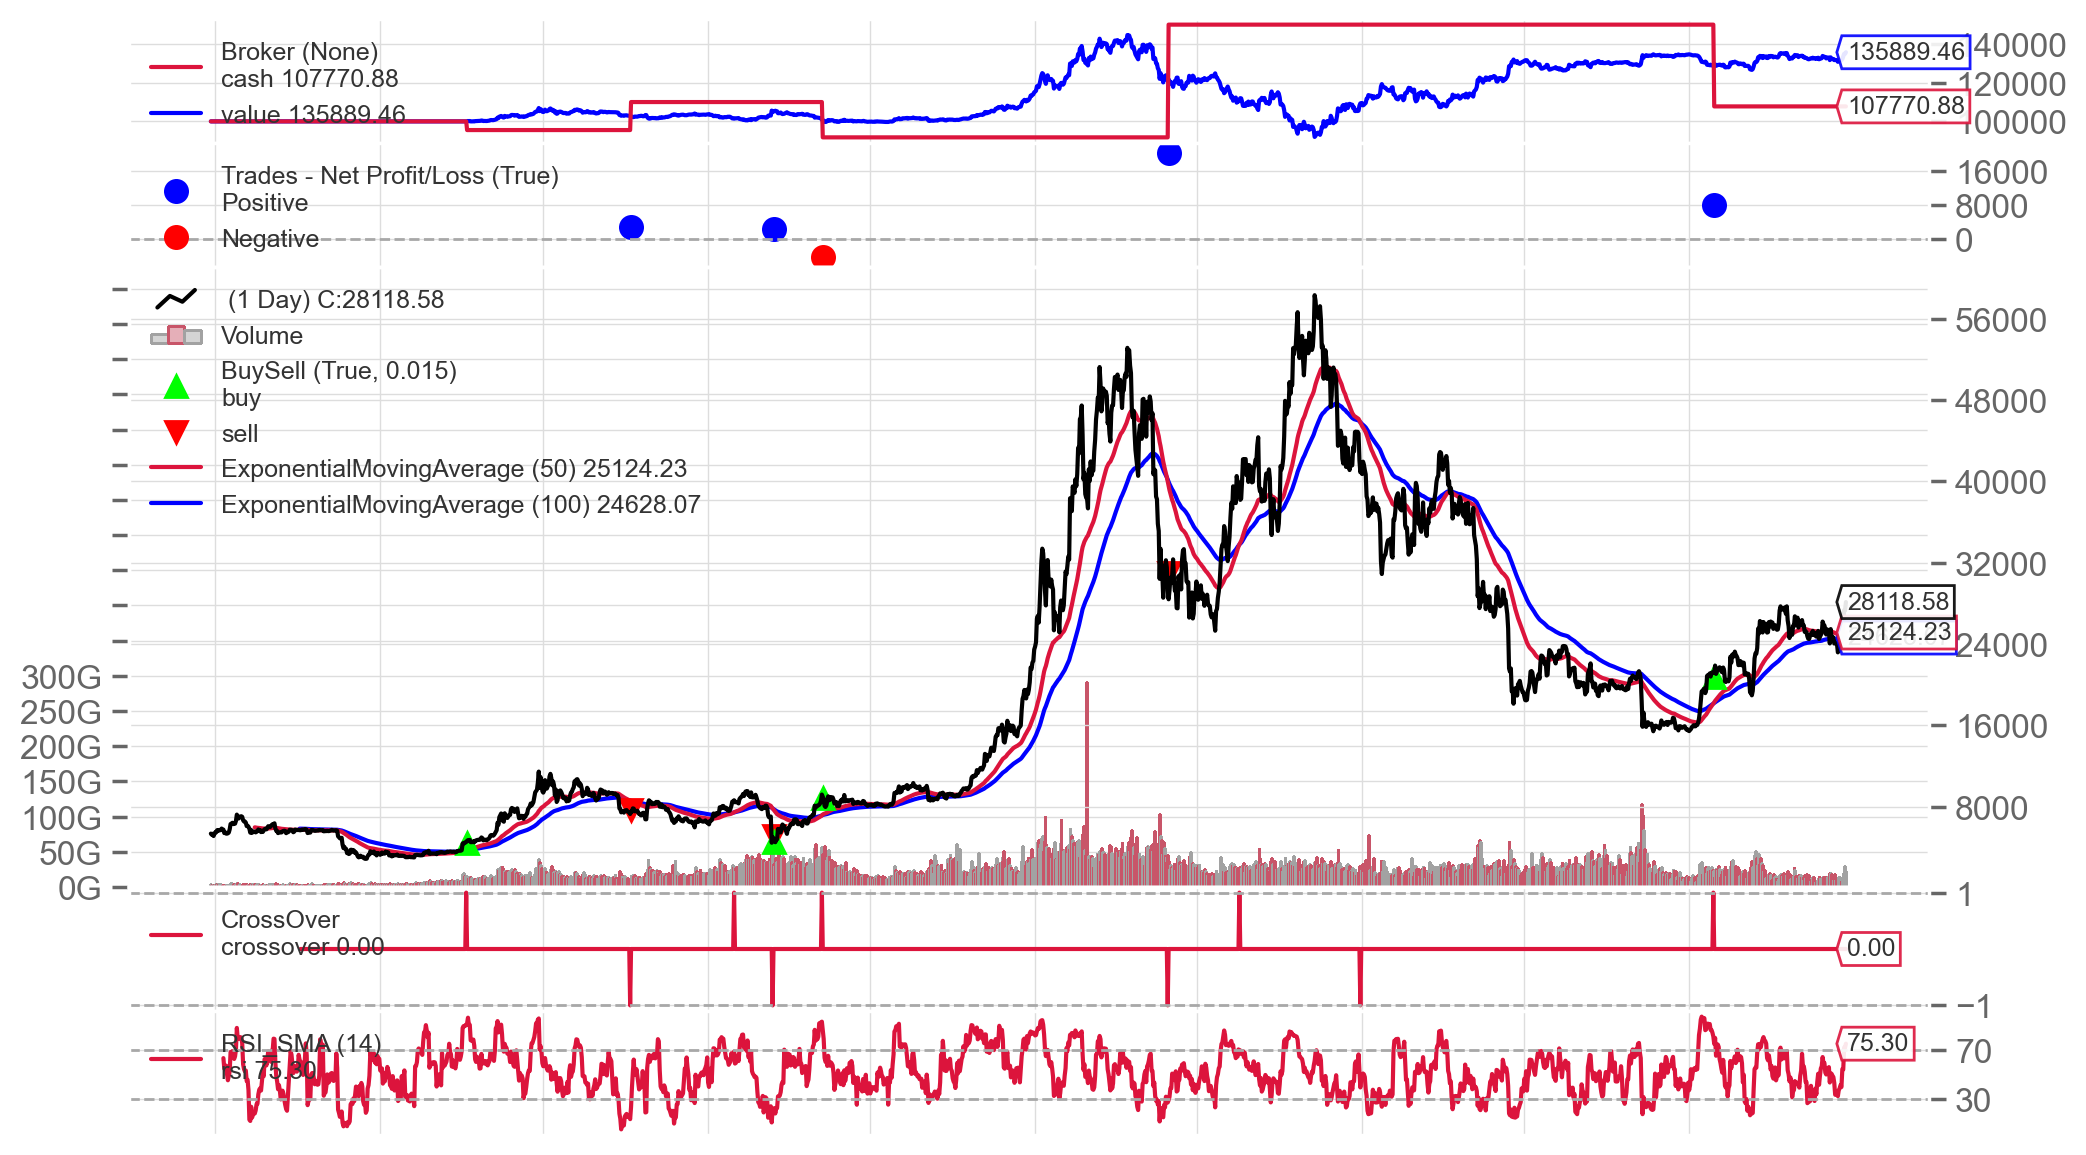

[[<Figure size 2000x1200 with 6 Axes>]]

In [13]:
%matplotlib inline
# Instantiating Cerebro engine
cerebro = bt.Cerebro()

# Adding the strategy to Cerebro
cerebro.addstrategy(MyStrategy)

# Adding the data feed to Cerebro
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

# Setting initial capital
initial_capital = 100000
cerebro.broker.setcash(initial_capital)

# Adding PyFolio analyzer
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Running the backtests
print('Starting Portfolio Value: {0:.2f}'.format(cerebro.broker.getvalue()))
results = cerebro.run()
print('Final Portfolio Value: {0:.2f}'.format(cerebro.broker.getvalue()))
cerebro.plot(iplot=False) # In case the plot doesn't show when running this cell, please run it again.

In [14]:
# Getting the analyzer results
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns = pyfoliozer.get_pf_items()[0]

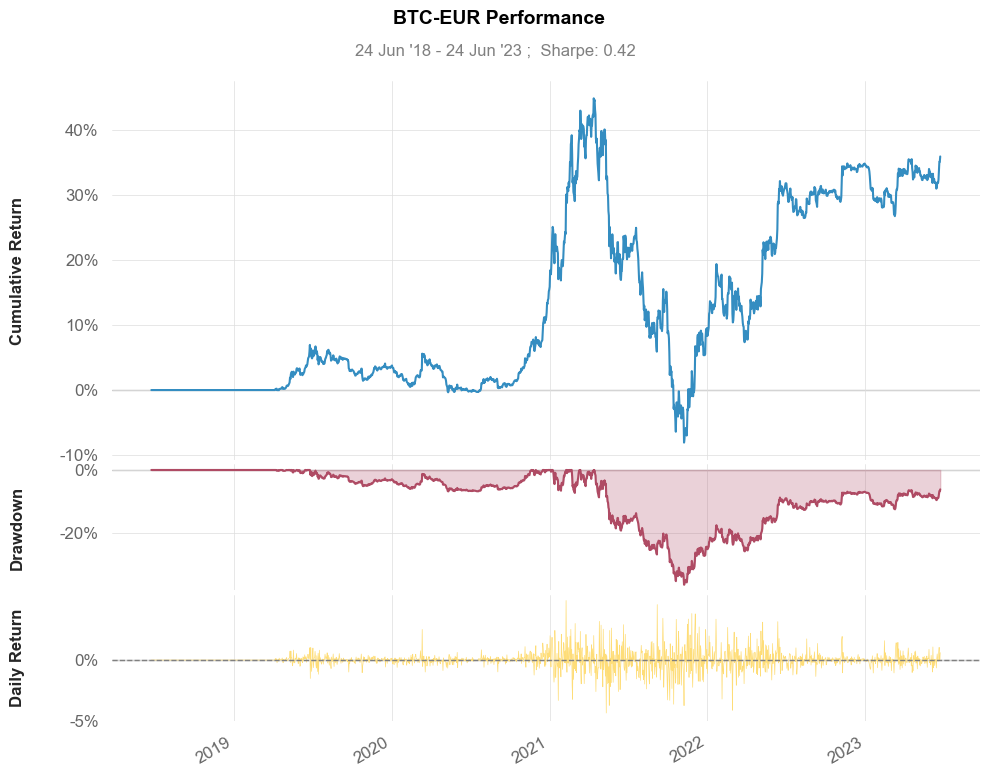

In [15]:
# Plotting the strategy performance
qs.plots.snapshot(returns, title='BTC-EUR Performance')

In [7]:
# Getting the performance measures of the strategy
qs.reports.metrics(returns, mode="full")

                           Strategy
-------------------------  ----------
Start Period               2018-06-25
End Period                 2023-06-24
Risk-Free Rate             0.0%
Time in Market             85.0%

Cumulative Return          35.89%
CAGR﹪                     4.33%

Sharpe                     0.42
Prob. Sharpe Ratio         87.2%
Smart Sharpe               0.41
Sortino                    0.62
Smart Sortino              0.61
Sortino/√2                 0.44
Smart Sortino/√2           0.43
Omega                      1.1

Max Drawdown               -36.52%
Longest DD Days            802
Volatility (ann.)          11.69%
Calmar                     0.12
Skew                       0.32
Kurtosis                   8.43

Expected Daily %           0.02%
Expected Monthly %         0.5%
Expected Yearly %          5.24%
Kelly Criterion            4.7%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.19%
Expected Shortfall (cVaR)  -1.19%

Max Consecutive Wins       8
Max

### Compound Annual Growth Rate (CAGR):

The CAGR is a financial metric used to calculate the annualized rate of return of an investment over a specified period of time. CAGR is useful for evaluating the performance of an investment or portfolio, especially when the investment experiences fluctuations in returns over the period. CAGR is particularly useful for comparing the performance of investments with different time frames or when there have been significant fluctuations in returns. It provides a standardized way of representing the annualized rate of growth, making it easier to compare investments on an "apples-to-apples" basis. 

The CAGR is defined as follows:
$$
CAGR=\left[\left(\frac{E V}{B V}\right)^{\frac{1}{n}}-1\right] \times 100,
$$
where $EV$ si the ending value, $BV$ is the begging value and $n$ is the number of years.

The result of $4.33\%$ considering the Risk-free interest $0\%$ in the exercise is a good return for low interest rate countries like Japan ($< 1\%$) but is not a good performance in emerging countries and high interest rate countries like Brazil ($13.75\%$).

### Sharpe Ratio:

The Sharpe ratio is a risk-adjusted performance measure that assesses the excess return of an investment or portfolio relative to its risk. It was developed by Nobel laureate William F. Sharpe and is widely used in the finance industry to evaluate the risk-adjusted return of an investment strategy. The Sharpe ratio is a valuable tool for investors and portfolio managers to make informed decisions, balancing returns and risk in their investment strategies. 

The Sharpe Ratio is defined as follows:
$$
\text { Sharpe } \text { Ratio }=\frac{R_p-R_f}{\sigma_p},
$$
where $R_p$ is the return of the asset, $R_f$ is the risk-free rate (in our case $R_f=0$) and $\sigma_p$ is the standard deviation of the asset return)

An excellent sharpe ratio is $> 1$ and a poor sharpe ratio is $< 0$. Considering the result of $0.42$ for an algorithm trading investment, it is fair.  You should compare with others trading in the market to make a better decision. The recent sharpe ratio of S&P500 is $0.73$, so the trading strategy is riskier than the index investment in this case.

### Maximum Drawdown:

The maximum drawdown is a risk metric that measures the maximum loss an investment or portfolio has experienced from its peak value to its lowest point over a specific period. In summary, the maximum drawdown is an essential metric used by investors to assess the worst-case loss potential of an investment or portfolio. It helps investors gauge the level of risk they are exposed to and evaluate their risk tolerance and suitability for a particular investment strategy.

In this case max drawdown is $-36.52\%$, which considering the 5 years period it seems fair. But that is a decision from the investor, which will have to understand that would be a potential maximum loss on its investment and if he is willing to accept this risk.

### Calmar Ratio:

The Calmar ratio is a risk-adjusted performance measure that evaluates the return of an investment or portfolio relative to its maximum drawdown. It is named after its creator, Jerry W. Calmar, who introduced the ratio as a way to assess hedge fund performance. 

$$
\text { Calmar Ratio }=\frac{R_p-R_f}{\text { Max Drawdown }},
$$
where $R_p$ is the annual rate of return and $R_f$ is the risk-free rate (in our case $R_f=0$).

Calmar ratio is a useful tool for investors and portfolio managers to evaluate the risk-adjusted performance of an investment or trading strategy. It provides insights into how well an investment has delivered returns relative to its downside risk, helping investors make informed decisions based on their risk preferences and return objectives.

An excellent calmar ratio is $> 1$ and a poor calmar ratio is $< 0$. Here is $0.12$, which seem close to Poor. While the interpretation of the Calmar ratio depends on the specific investment strategy, market conditions, and risk tolerance of the investor, a Calmar ratio of $0.12$ may not be considered desirable by many investors, especially those who prioritize risk-adjusted returns and downside protection.

The performance ratios analysis must be taken in consideration that we cannot evaluate an investment by an individual measure, and the profile of investor (aggressive, moderate, or conservative) is the best driver to understand if the investment fits with the balance of risk and return acceptable.

In [8]:
# Defining the parameter grid
param_grid = {
    'ema1_period': range(5, 51, 5), # Values for the shorter-term EMA
    'ema2_period': range(80, 151, 10), # Values for the longer-term EMA
    'period': range(14,21) # Values for the RSI
}

In [9]:
# Defining the split date
split_date = "2021-06-25"

# Splitting the data into training and testing periods
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Creating data feeds for training and testing
train_feed = bt.feeds.PandasData(dataname=train_data)
test_feed = bt.feeds.PandasData(dataname=test_data)

In [10]:
# Defining a function to evaluate the strategy with given parameters
def evaluate_strategy(params):
    cerebro = bt.Cerebro()
    cerebro.adddata(train_feed)

    cerebro.addstrategy(MyStrategy, **params)

    initial_capital = cerebro.broker.getvalue()

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)

    result = cerebro.run()

    # Calculating the pnl and the sharpe ratio
    pnl = cerebro.broker.getvalue() - initial_capital
    sharpe_ratio = result[0].analyzers.sharperatio.get_analysis()['sharperatio']

    return round(pnl, 2), round(sharpe_ratio, 4)

In [11]:
from tqdm import tqdm

# Defining an empty list to store the results
results = []

# Creating a tqdm progress bar with the total number of iterations
total_iterations = len(list(itertools.product(*param_grid.values())))
progress_bar = tqdm(total=total_iterations, desc='Progress', unit='iteration')

# Performing grid search
for params in itertools.product(*param_grid.values()):
    param_combination = dict(zip(param_grid.keys(), params))
    pnl, sharpe_ratio = evaluate_strategy(param_combination)

    # Appending the results to the list
    results.append((param_combination['ema1_period'], param_combination['ema2_period'],
                    param_combination['period'], pnl, sharpe_ratio))

    # Updating the progress bar
    progress_bar.update(1)

# Closing the progress bar
progress_bar.close()

# Creating a dataframe from the results list
df_results = pd.DataFrame(results, columns=['EMA1', 'EMA2', 'RSI',
                                            'Total Return', 'Sharpe Ratio'])

# Sorting the dataframe by the highest total return of the strategy
df_results = df_results.sort_values(by='Total Return', ascending=False) 

df_results

Progress: 100%|██████████| 560/560 [01:03<00:00,  8.78iteration/s]


,EMA1,EMA2,RSI,Total Return,Sharpe Ratio
21,5,110,14,41271.06,1.0534
56,10,80,14,41271.06,1.0534
64,10,90,15,41187.14,1.0555
30,5,120,16,40386.10,1.0585
28,5,120,14,40386.10,1.0585
...,...,...,...,...,...
75,10,100,19,-22925.70,-0.2485
76,10,100,20,-22925.70,-0.2485
83,10,110,20,-22925.70,-0.2485
125,15,90,20,-23210.82,-0.2615


In [12]:
# P/L and Sharpe Ration during the backtest
cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy, ema1_period=5, ema2_period=110, period=14) # Considering the best params found in the grid search
cerebro.adddata(train_feed)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
init_value = cerebro.broker.getvalue()
results = cerebro.run()
print('P/L of the strategy during the backtest: {:.2f}'.format(cerebro.broker.getvalue()-init_value))
print('Sharpe Ratio during the backtest: {:.4f}'.format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']))

# P/L and Sharpe Ration out of sample
cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy, ema1_period=5, ema2_period=110, period=14)
cerebro.adddata(test_feed)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, annualize=True)
init_value = cerebro.broker.getvalue()
results = cerebro.run()
print('P/L of the strategy out of sample: {:.2f}'.format(cerebro.broker.getvalue()-init_value))
print('Sharpe Ratio out of sample: {:.4f}'.format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']))

P/L of the strategy during the backtest: 41271.06
Sharpe Ratio during the backtest: 1.0534
P/L of the strategy out of sample: 11200.43
Sharpe Ratio out of sample: 0.6041
